# Top down growth chamber analysis with plantCV

Following the [this guide](https://plantcv.readthedocs.io/en/stable/tutorials/arabidopsis_multi_plant_tutorial/) with some slight augmentations 

Will need to work on getting to the data. It would be nice if we could use rclone to sync up to the google drive location where the images are being stored like this: 
```bash
rclone mount --allow-non-empty --vfs-cache-mode full google_drive:/rpi-folder/ ./data 
```
* The `mount` option in rclone will treat the remote source like an external storage drive. This may become a problem when processing many images at once because technically there is a limit to how many requests we can cend to google drive (on a per minute basis)        
* `--allow-non-empty` refers to the local destination file at the end (`./data`). The files in the folder don't get overwritten and they reappear after the connection is broken. 
- `-vfs-cache-mode full` refers to the caching mode used by rclone. In this case, the `full` mode is used, which caches all files in memory for faster access.

In [1]:
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs
import matplotlib.pyplot as plt

In [2]:
import glob
# Define the naming scheme
naming_scheme = "./data/topview_*.jpg"
# Get all file names that match the naming scheme
image_filenames = glob.glob(naming_scheme)

batch = []
for path in image_filenames:
    file_parts = path.split("_")
    date = file_parts[1].split("-")
    time = file_parts[2].split(":")
    #only pulling the pictures from one day
    if date[1] == "08" and date[2] == "08":
        batch.append(path)        


In [3]:
# Input/output options
args = WorkflowInputs(
    images=batch,    
    names="image1",
    result="topview_results",
    outdir=".",
    writeimg=True,
    debug="plot",
    sample_label="plant"
    )
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Set plotting size (default = 100)
pcv.params.dpi = 200
# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20


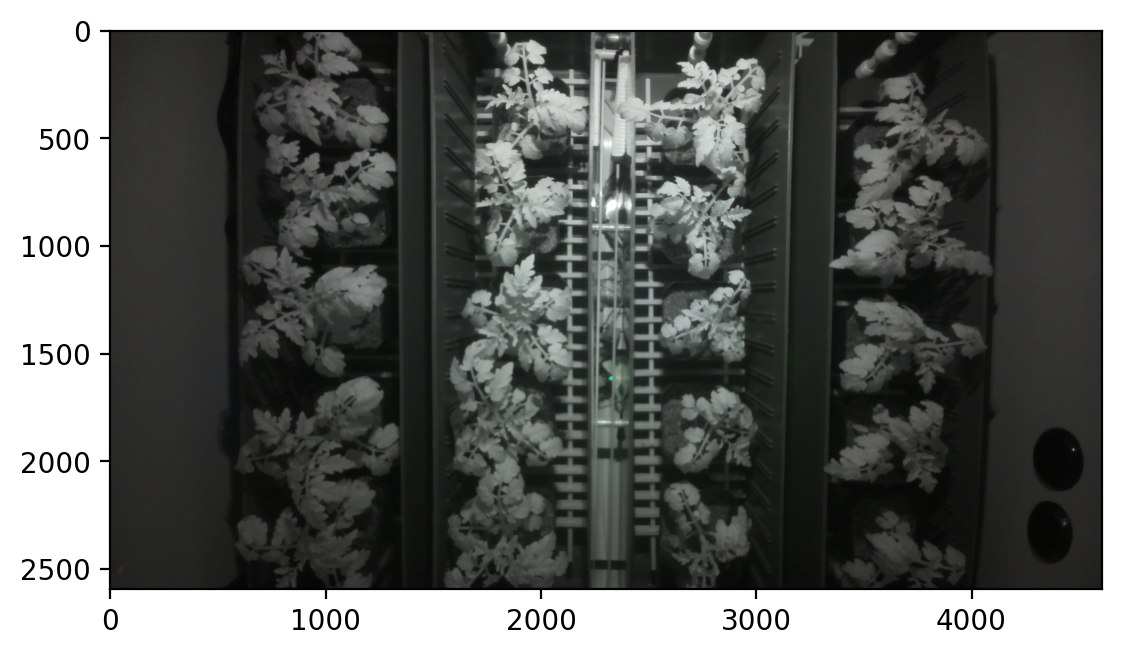

In [4]:
img, path, filename = pcv.readimage(filename=args.image1)
img = img[:, 500:4000, :]

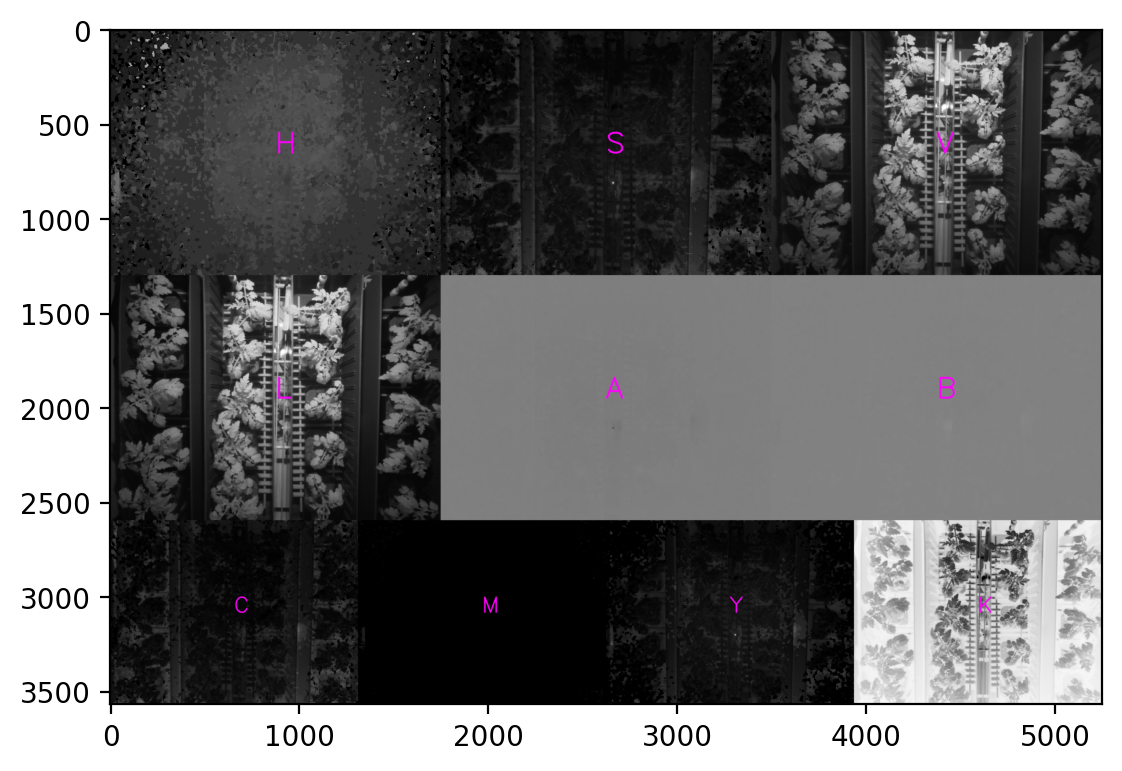

In [5]:
colorspaces = pcv.visualize.colorspaces(rgb_img=img, original_img=False)

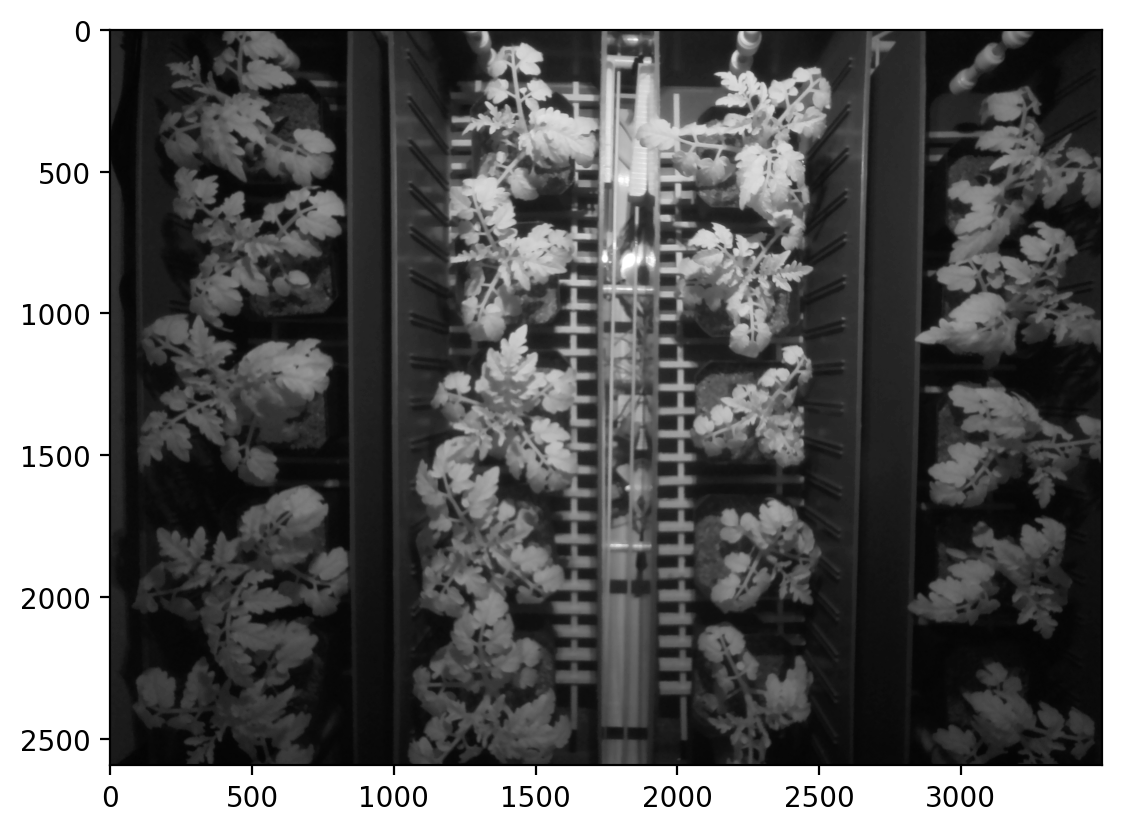

In [6]:
a = pcv.rgb2gray_lab(rgb_img=img, channel='l')

In [7]:
hist = pcv.visualize.histogram(img=a, bins=25)

alt.Chart(...)

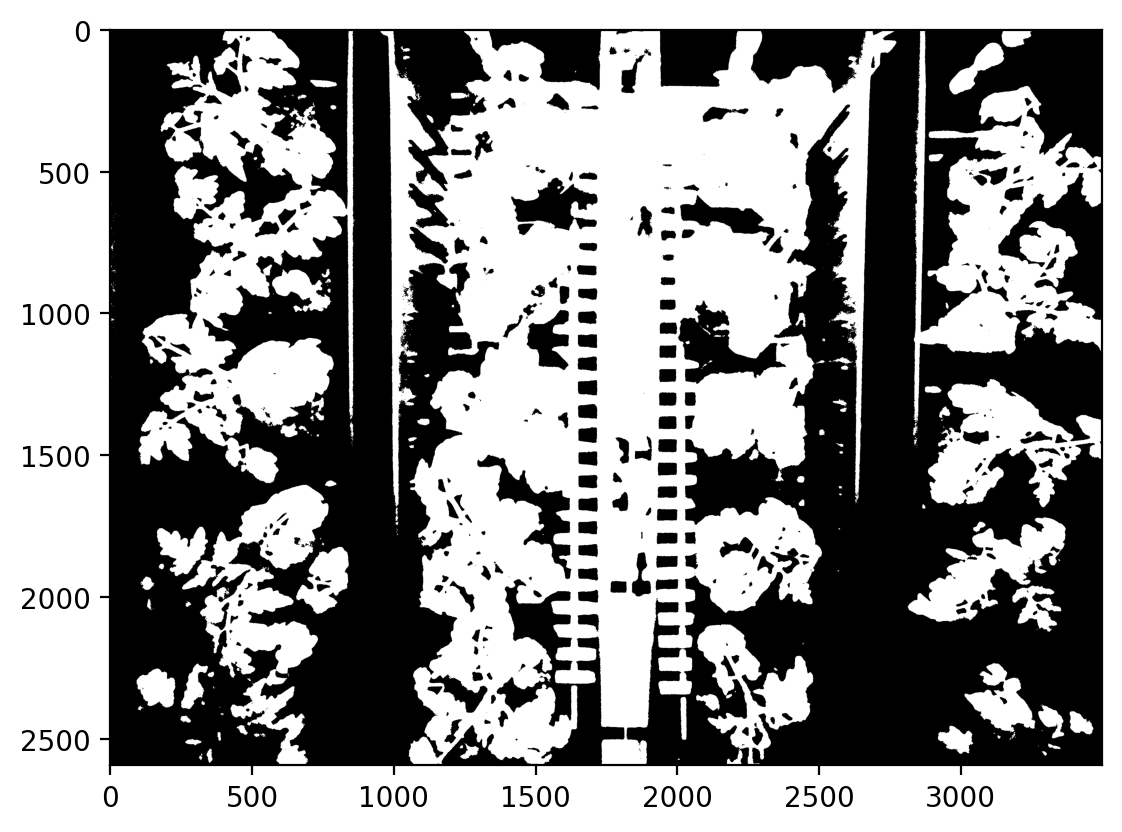

In [12]:
a_thresh = pcv.threshold.binary(gray_img=a, threshold=50, object_type='light')

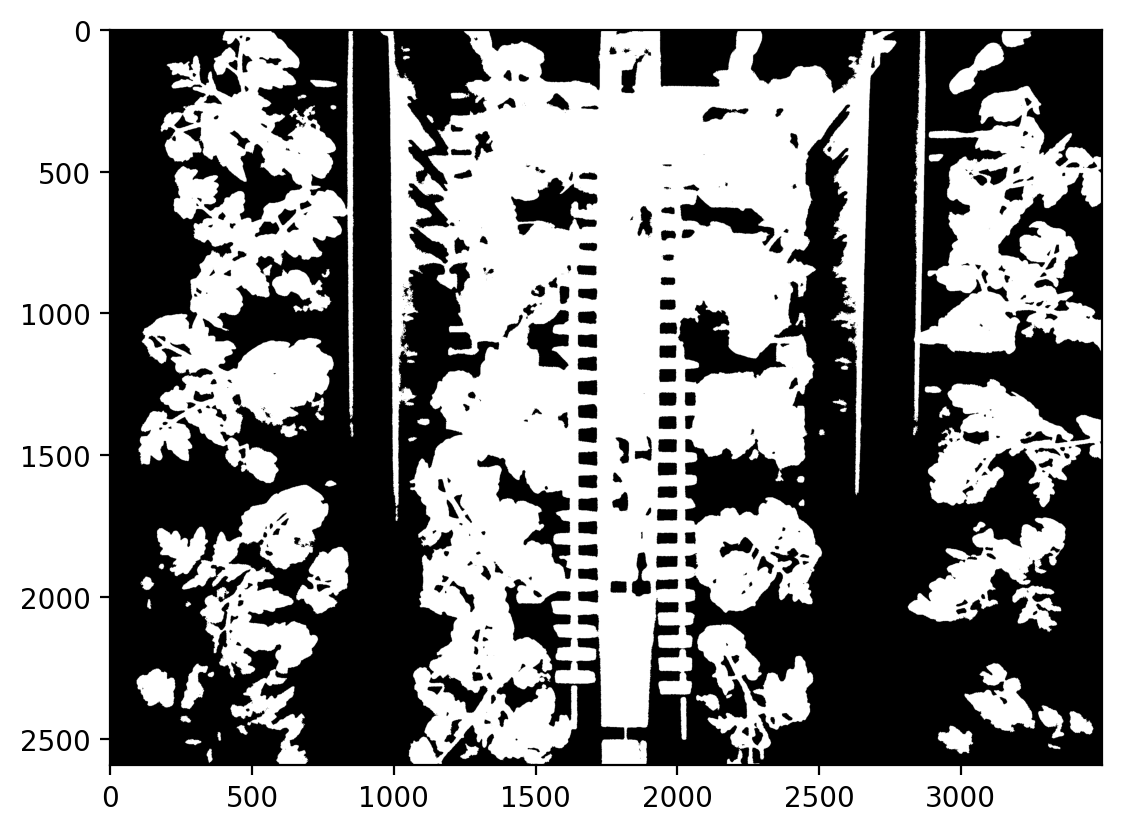

In [13]:
a_fill = pcv.fill(bin_img=a_thresh, size=200)

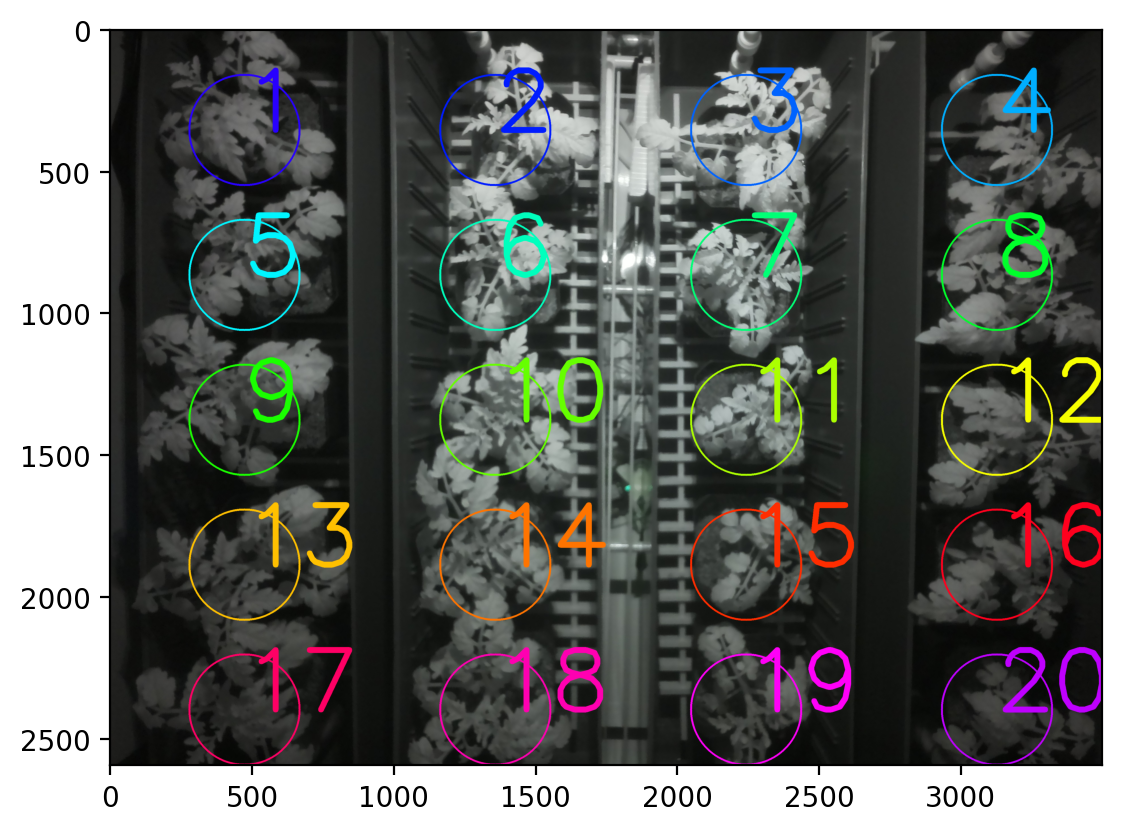

In [14]:
rois = pcv.roi.auto_grid(mask=a_fill, nrows=5, ncols=4, img=img)
# There is no way to change the spacing unless we fork plantCV and chnage it ourselves

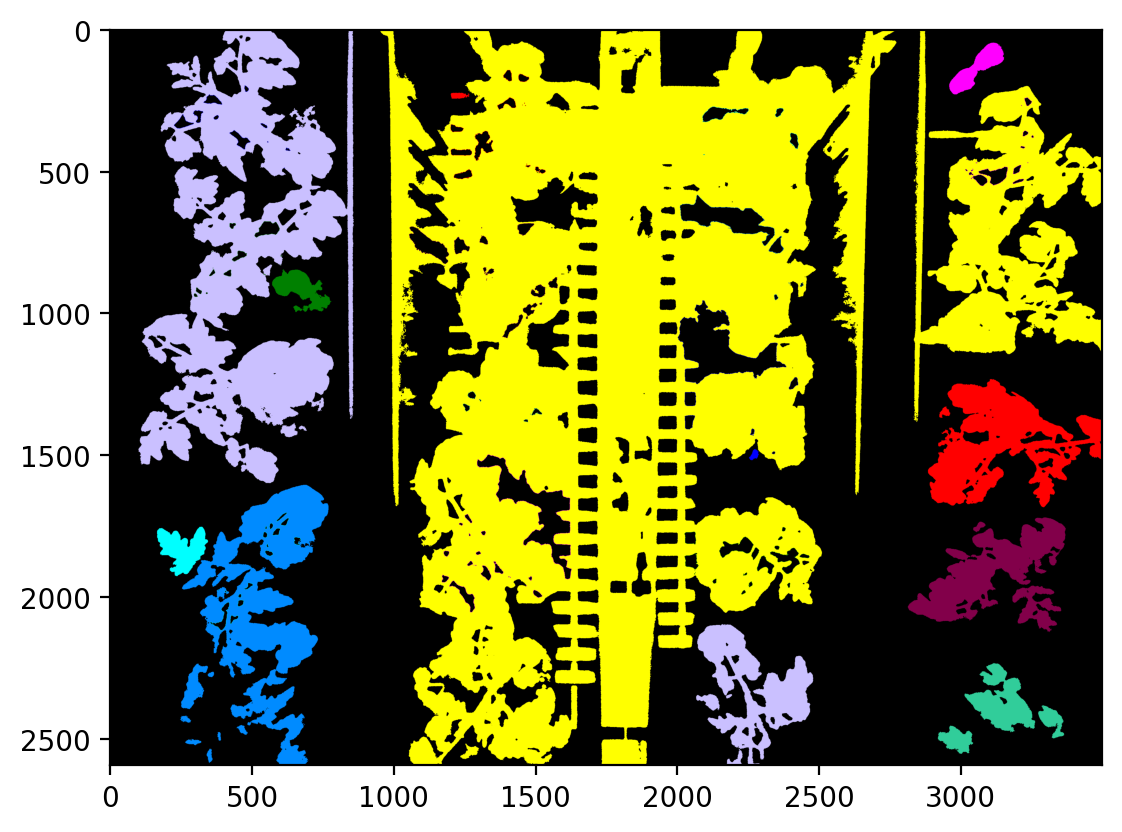

In [15]:
labeled_mask, num_plants = pcv.create_labels(mask=a_fill, rois=rois, roi_type="partial")

So all the work so far has been to create this labeled mask. This is image segmentation. A problem that plagues all of my projects.

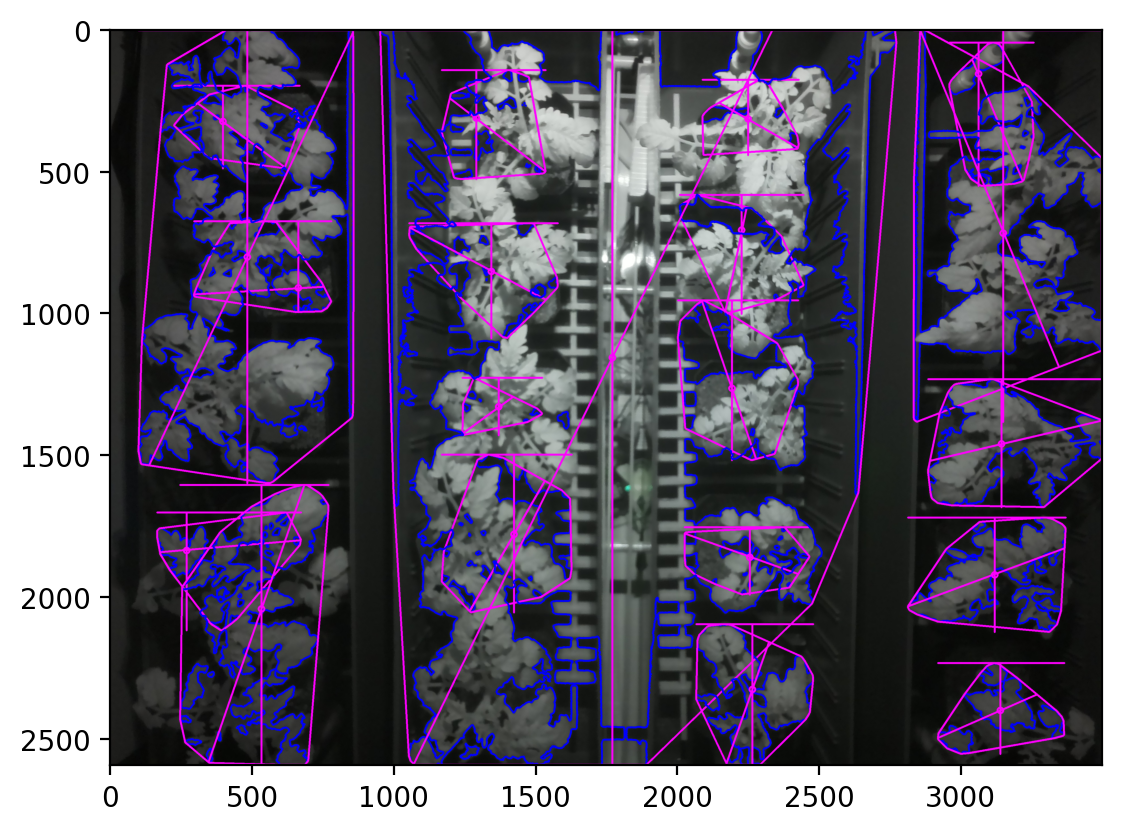

In [16]:
shape_img = pcv.analyze.size(img=img, labeled_mask=labeled_mask, n_labels=20)

In [17]:
shape_img = pcv.analyze.color(rgb_img=img, labeled_mask=labeled_mask, n_labels=20, colorspaces="HSV")

alt.FacetChart(...)

In [18]:
pcv.outputs.save_results(filename=args.result)